# Descriptions
Ref:  
- [module: ktrain](https://github.com/amaiya/ktrain)

- BERT stands for Bidirectional Encoder Representations from Transformers
- BERT was developed by researchers at Google in 2018
- BERT is a text representation technique like Word Embeddings.

# Google Colab

In [1]:
%%capture
# capture will not print in notebook

import os
import sys
ENV_COLAB = 'google.colab' in sys.modules

if ENV_COLAB:
    ## install modules
    !pip install -q ktrain
    !pip install -q git+https://github.com/amaiya/eli5@tfkeras_0_10_1
    !pip install -q neptune-client neptune-contrib
    !pip install -q scikit-plot

    ## print
    print('Environment: Google Colaboratory.')

# NOTE: If we update modules in gcolab, we need to restart runtime.

In [14]:
import tensorflow as tf
import ktrain

from pprint import pprint

versions_dl = [(x.__name__,x.__version__) for x in [tf, ktrain]]
pprint(versions_dl)

[('tensorflow', '2.3.0'), ('ktrain', '0.21.2')]


In [3]:
import neptune
from neptunecontrib.api import log_table

In [4]:
# use your real key and DELETE the cell

# neptune.init('bhishanpdl/twitter-sentiment-analysis','your_api_key')

In [15]:
neptune.create_experiment(
    name='ktrain', # put small name
    description='',
    tags = ['ktrain', 'bert'],
    upload_source_files=None
)

https://ui.neptune.ai/bhishanpdl/twitter-sentiment-analysis/e/TWITSENT-11


Experiment(TWITSENT-11)

In [17]:
neptune.log_text('versions_dl', str(versions_dl))

# Load the libraries

In [18]:
import numpy as np
import pandas as pd

pd.set_option('max_colwidth',200)
pd.set_option('max_columns',200)
SEED = 100

import sys
import re
from tqdm import tqdm
tqdm.pandas()

versions_ds = [(x.__name__,x.__version__) for x in [np,pd]]
pprint(versions_ds)

[('numpy', '1.18.5'), ('pandas', '1.0.5')]


In [19]:
neptune.log_text('versions_ds', str(versions_ds))

# Load the data

In [11]:
target = 'label'
maincol = 'tweet'

p = 'https://github.com/bhishanpdl/Datasets/blob/master/AV_Hackathons/sentiment_analysis/processed/'
df_combined = pd.read_csv(p + 'df_combined_clean.csv?raw=true')

df_train = df_combined[~df_combined[target].isnull()]
df_test = df_combined[df_combined[target].isnull()]

print(f"train : {df_train.shape}")
print(f"test : {df_test.shape}")
display(df_train.head(2).append(df_train.tail(2)))

train : (7920, 24)
test : (1953, 24)


,index,id,label,tweet,tweet_lst_clean,tweet_clean,hashtags_lst,hashtags,total_length,num_words,num_sent,num_unique_words,num_words_title,num_uppercase,num_exclamation_marks,num_question_marks,num_punctuation,num_symbols,num_digits,avg_word_len,avg_uppercase,avg_unique,tweet_lst_clean_emoji,tweet_clean_emoji
0,0,1,0.0,#fingerprint #Pregnancy Test https://goo.gl/h1MfQV #android #apps #beautiful #cute #health #igers #iphoneonly #iphonesia #iphone,"['fingerprint', 'pregnancy', 'test', 'android', 'aps', 'beautiful', 'cute', 'health', 'igers', 'iphoneonly', 'iphonesia', 'iphone']",fingerprint pregnancy test android aps beautiful cute health igers iphoneonly iphonesia iphone,"['#fingerprint', '#Pregnancy', '#android', '#apps', '#beautiful', '#cute', '#health', '#igers', '#iphoneonly', '#iphonesia', '#iphone']",#fingerprint #Pregnancy #android #apps #beautiful #cute #health #igers #iphoneonly #iphonesia #iphone,128,13,1,13,2,5,0,0,2,0,0,8.923077,0.039062,1.0,"['fingerprint', 'pregnancy', 'test', 'android', 'aps', 'beautiful', 'cute', 'health', 'iger', 'iphone', 'iphones', 'iphone']",fingerprint pregnancy test android aps beautiful cute health iger iphone iphones iphone
1,1,2,0.0,Finally a transparant silicon case ^^ Thanks to my uncle :) #yay #Sony #Xperia #S #sonyexperias… http://instagram.com/p/YGEt5JC6JM/,"['finaly', 'transparant', 'silicon', 'case', 'thanks', 'uncle', 'yay', 'sony', 'xperia', 'sonyexperias']",finaly transparant silicon case thanks uncle yay sony xperia sonyexperias,"['#yay', '#Sony', '#Xperia', '#S', '#sonyexperias…']",#yay #Sony #Xperia #S #sonyexperias…,131,17,1,17,5,12,0,0,3,0,0,6.764706,0.091603,1.0,"['finaly', 'trans', 'paran', 'silicon', 'case', 'thanks', 'uncle', 'yay', 'sony', 'x', 'peri', 'sony', 'ex', 'peri']",finaly trans paran silicon case thanks uncle yay sony x peri sony ex peri
7918,7918,7919,0.0,"Finally got my #smart #pocket #wifi stay connected anytime,anywhere! #ipad and #samsung #s3 #gadget # http://instagr.am/p/U-53G_vJU8/","['finaly', 'got', 'smart', 'pocket', 'wifi', 'stay', 'conected', 'anytimeanywhere', 'ipad', 'samsung', 'gadget']",finaly got smart pocket wifi stay conected anytimeanywhere ipad samsung gadget,"['#smart', '#pocket', '#wifi', '#ipad', '#samsung', '#s3', '#gadget', '#']",#smart #pocket #wifi #ipad #samsung #s3 #gadget #,133,16,1,16,1,5,1,0,3,0,0,7.375000,0.037594,1.0,"['finaly', 'got', 'smart', 'pocket', 'wi', 'fi', 'stay', 'conected', 'anytime', 'anywhere', 'ipad', 'samsung', 'gadget']",finaly got smart pocket wi fi stay conected anytime anywhere ipad samsung gadget
7919,7919,7920,0.0,Apple Barcelona!!! #Apple #Store #BCN #Barcelona #travel #iphone #selfie #fly #fun #cabincrew… http://instagram.com/p/wBApVzpCl3/,"['aple', 'barcelona', 'aple', 'store', 'bcn', 'barcelona', 'travel', 'iphone', 'selfie', 'fly', 'fun', 'cabincrew']",aple barcelona aple store bcn barcelona travel iphone selfie fly fun cabincrew,"['#Apple', '#Store', '#BCN', '#Barcelona', '#travel', '#iphone', '#selfie', '#fly', '#fun', '#cabincrew…']",#Apple #Store #BCN #Barcelona #travel #iphone #selfie #fly #fun #cabincrew…,129,13,1,13,5,12,3,0,2,0,0,9.000000,0.093023,1.0,"['aple', 'barcelona', 'aple', 'store', 'n', 'barcelona', 'travel', 'iphone', 'self', 'ie', 'fly', 'fun', 'cabin', 'crew']",aple barcelona aple store n barcelona travel iphone self ie fly fun cabin crew


In [12]:
display(df_test.head(2).append(df_test.tail(2)))

,index,id,label,tweet,tweet_lst_clean,tweet_clean,hashtags_lst,hashtags,total_length,num_words,num_sent,num_unique_words,num_words_title,num_uppercase,num_exclamation_marks,num_question_marks,num_punctuation,num_symbols,num_digits,avg_word_len,avg_uppercase,avg_unique,tweet_lst_clean_emoji,tweet_clean_emoji
7920,0,7921,NaN,I hate the new #iphone upgrade. Won't let me download apps. #ugh #apple sucks,"['hate', 'new', 'iphone', 'upgrade', 'wil', 'let', 'download', 'aps', 'ugh', 'aple', 'suck']",hate new iphone upgrade wil let download aps ugh aple suck,"['#iphone', '#ugh', '#apple']",#iphone #ugh #apple,77,14,1,14,1,2,0,0,2,0,0,4.571429,0.025974,1.000000,"['hate', 'new', 'iphone', 'upgrade', 'wil', 'let', 'download', 'aps', 'ugh', 'aple', 'suck']",hate new iphone upgrade wil let download aps ugh aple suck
7921,1,7922,NaN,currently shitting my fucking pants. #apple #iMac #cashmoney #raddest #swagswagswag http://instagr.am/p/UUIS0bIBZo/,"['curently', 'shiting', 'fucking', 'pant', 'aple', 'imac', 'cashmoney', 'radest', 'swagswag']",curently shiting fucking pant aple imac cashmoney radest swagswag,"['#apple', '#iMac', '#cashmoney', '#raddest', '#swagswagswag']",#apple #iMac #cashmoney #raddest #swagswagswag,115,11,1,11,0,8,0,0,3,0,0,9.545455,0.069565,1.000000,"['curently', 'shiting', 'fucking', 'pant', 'aple', 'imac', 'cash', 'money', 'rad', 'de', 'st', 'swag', 'wag', 'wag']",curently shiting fucking pant aple imac cash money rad de st swag wag wag
9871,1951,9872,NaN,@codeofinterest as i said #Adobe big time we may well as include #apple to,"['codeofinterest', 'said', 'adobe', 'big', 'time', 'may', 'wel', 'include', 'aple']",codeofinterest said adobe big time may wel include aple,"['#Adobe', '#apple']",#Adobe #apple,74,14,1,13,1,1,0,0,0,0,0,4.357143,0.013514,0.928571,"['code', 'interest', 'said', 'adobe', 'big', 'time', 'may', 'wel', 'include', 'aple']",code interest said adobe big time may wel include aple
9872,1952,9873,NaN,Finally I got it .. thanx my father .. #Samsung #galaxy #s3 #gift #father #phone #new http://instagr.am/p/NoxkiPE,"['finaly', 'got', 'thanx', 'father', 'samsung', 'galaxy', 'gift', 'father', 'phone', 'new']",finaly got thanx father samsung galaxy gift father phone new,"['#Samsung', '#galaxy', '#s3', '#gift', '#father', '#phone', '#new']",#Samsung #galaxy #s3 #gift #father #phone #new,113,17,1,16,3,6,0,0,6,0,0,5.705882,0.053097,0.941176,"['finaly', 'got', 'x', 'father', 'samsung', 'galaxy', 'gift', 'father', 'phone', 'new']",finaly got x father samsung galaxy gift father phone new


In [20]:
neptune.log_text('text processing', 'detailed text processing')

# Train Validation split using ktrain

In [ ]:
# [i for i in dir(ktrain.text) if i[0]!='_']

# ktrain.text.texts_from_df?

In [237]:
maincol = 'tweet' # the raw data gave me much better result.
neptune.log_text('column_used', maincol)

In [238]:
%%time

# bert is uncased_L-12_H-768_A-12.zip
MODEL_NAME = 'bert' # distilbert gives error
neptune.log_text('text_model', MODEL_NAME )

# Parameters
PARAMS = dict()
PARAMS['ngram_range'] = 1
PARAMS['max_features'] = 20000
PARAMS['maxlen'] = 300
for k,v in PARAMS.items():
    neptune.log_metric(k,v)


(X_train, y_train), (X_valid, y_valid), preproc = \
ktrain.text.texts_from_df(df_train,
    text_column=maincol,
    label_columns=[target],
    random_state=SEED,
    ngram_range=PARAMS['ngram_range'] ,
    max_features=PARAMS['max_features'],
    val_df = None, # if not 10% of train is used
    maxlen=PARAMS['maxlen'], # it was 500
    preprocess_mode=MODEL_NAME )

model = ktrain.text.text_classifier(name=MODEL_NAME ,
                             train_data=(X_train, y_train),
                             metrics=['accuracy'],
                             preproc=preproc)

learner = ktrain.get_learner(model=model,
                             train_data=(X_train, y_train),
                             val_data=(X_valid, y_valid),
                             batch_size=6)

preprocessing train...
language: en


Is Multi-Label? False
preprocessing test...
language: en


Is Multi-Label? False
maxlen is 300
done.
CPU times: user 6.6 s, sys: 835 ms, total: 7.44 s
Wall time: 8.43 s


In [239]:
# ktrain.text.text_classifier?

In [240]:
type(X_train), X_train[0].shape, X_valid[0].shape

(list, (7128, 300), (792, 300))

## Train Validation split using sklearn

Official tutorial: https://nbviewer.jupyter.org/github/amaiya/ktrain/blob/master/tutorials/tutorial-A3-hugging_face_transformers.ipynb

In [241]:
# from sklearn.model_selection import train_test_split
# X_train,X_valid, y_train, y_valid = train_test_split(df_train[maincol].to_numpy().ravel(),
#                                                      df_train[target].to_numpy().ravel(),
#                                                      random_state=SEED,
#                                                      stratify=df_train[target])

# MODEL_NAME = 'distilbert-base-uncased'
# transformer = ktrain.text.Transformer(MODEL_NAME, maxlen=500,class_names=df_train[target].unique().tolist())

# data_train = transformer.preprocess_train(X_train, y_train)
# data_valid = transformer.preprocess_test(X_valid, y_valid)
# model = transformer.get_classifier()
# learner = ktrain.get_learner(model, train_data=data_train, val_data=data_valid, batch_size=6)

# print(type(data_train))

# Text Modelling: ktrain and bert

name is one of:
```
'fasttext' 'nbsvm' 'logreg'  'bigru'  'bert' 'distilbert' 
```

In [242]:
# ktrain.text.text_classifier?

In [243]:
ktrain.text.print_text_classifiers()

fasttext: a fastText-like model [http://arxiv.org/pdf/1607.01759.pdf]
logreg: logistic regression using a trainable Embedding layer
nbsvm: NBSVM model [http://www.aclweb.org/anthology/P12-2018]
bigru: Bidirectional GRU with pretrained fasttext word vectors [https://fasttext.cc/docs/en/crawl-vectors.html]
standard_gru: simple 2-layer GRU with randomly initialized embeddings
bert: Bidirectional Encoder Representations from Transformers (BERT) [https://arxiv.org/abs/1810.04805]
distilbert: distilled, smaller, and faster BERT from Hugging Face [https://arxiv.org/abs/1910.01108]


In [244]:
# [i for i in dir(model) if i[0]!='_']

In [245]:
# [i for i in dir(learner) if i[0]!='_']

In [246]:
# # find good learning rate
# learner.lr_find()             # briefly simulate training to find good learning rate
# learner.lr_plot()             # visually identify best learning rate

# usually 2e-5 is the better option.

In [247]:
# %%time
# learner.lr_find(show_plot=True, max_epochs=2)
# I have found lr = 2e-5 as good

In [283]:
%%time
# use gpu
PARAMS = {'lr': 2e-5, # it was 2e-5
          'epochs': 2 # best so far was 5
          }

for k,v in PARAMS.items():
    neptune.log_metric(k,v)

learner.fit_onecycle(**PARAMS)



begin training using onecycle policy with max lr of 2e-05...
Epoch 1/2
1188/1188 [==============================] - 793s 668ms/step - loss: 0.0241 - accuracy: 0.9917 - val_loss: 0.3395 - val_accuracy: 0.9154
Epoch 2/2
1188/1188 [==============================] - 790s 665ms/step - loss: 0.0279 - accuracy: 0.9903 - val_loss: 0.3667 - val_accuracy: 0.9167
CPU times: user 23min 26s, sys: 5min 12s, total: 28min 39s
Wall time: 26min 24s


In [284]:
neptune.log_text('last_epoch','loss: 0.0279 - accuracy: 0.9903 - val_loss: 0.3667 - val_accuracy: 0.9167')

In [285]:
neptune.log_metric('fit_onecycle_time_min',27 )

In [195]:
# [i for i in dir(learner) if i[0]!='_']

In [196]:
# learner.save_model('ktrain_learner_maincol')
# !du -sh ktrain_learner_maincol/tf_model.h5

# 1.3G

In [286]:
%%time
learner.validate(val_data=(X_valid, y_valid))

              precision    recall  f1-score   support

           0       0.96      0.92      0.94       599
           1       0.79      0.89      0.84       193

    accuracy                           0.92       792
   macro avg       0.88      0.91      0.89       792
weighted avg       0.92      0.92      0.92       792

CPU times: user 1.68 s, sys: 774 ms, total: 2.46 s
Wall time: 18.7 s


array([[554,  45],
       [ 21, 172]])

In [287]:
print([i for i in dir(learner) if i[0]!='_'])

['autofit', 'batch_size', 'eval_batch_size', 'evaluate', 'fit', 'fit_onecycle', 'freeze', 'get_weight_decay', 'ground_truth', 'history', 'layer_output', 'load_model', 'lr_estimate', 'lr_find', 'lr_finder', 'lr_plot', 'model', 'multigpu', 'plot', 'predict', 'print_layers', 'reset_weights', 'save_model', 'set_lr', 'set_model', 'set_weight_decay', 'top_losses', 'train_data', 'unfreeze', 'use_multiprocessing', 'val_data', 'validate', 'view_top_losses', 'workers']


In [288]:
# learner.evaluate()


In [289]:
clf_report = """
              precision    recall  f1-score   support

           0       0.96      0.92      0.94       599
           1       0.79      0.89      0.84       193

    accuracy                           0.92       792
   macro avg       0.88      0.91      0.89       792
weighted avg       0.92      0.92      0.92       792

CPU times: user 1.68 s, sys: 774 ms, total: 2.46 s
Wall time: 18.7 s
array([[554,  45],
       [ 21, 172]])

"""

neptune.log_text('clf_report',clf_report)

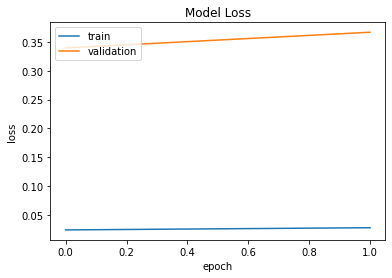

In [290]:
loss_plot = learner.plot() # this returns None

# Model Evaluation on Validation Data

In [291]:
X_valid

[array([[ 101, 2003, 2026, ...,    0,    0,    0],
        [ 101, 4569, 2051, ...,    0,    0,    0],
        [ 101, 2190, 1056, ...,    0,    0,    0],
        ...,
        [ 101, 1011, 2061, ...,    0,    0,    0],
        [ 101, 2204, 2851, ...,    0,    0,    0],
        [ 101, 2054, 2003, ...,    0,    0,    0]]),
 array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]])]

In [292]:
# valid_probs2d = learner.predict(val_data=(X_valid,y_valid))
print(f'val probs2d shape: {val_probs2d.shape}')
valid_probs2d[0]

val probs2d shape: (792, 2)


array([9.997271e-01, 2.728660e-04], dtype=float32)

In [293]:
valid_preds = (valid_probs2d[:,1]>0.5).astype(int).tolist()
len(valid_preds)

792

In [294]:
y_valid.shape, y_valid[0]

((792, 2), array([1., 0.], dtype=float32))

In [295]:
lst_y_valid = (y_valid[:,1].tolist())
lst_y_valid[:5]

[0.0, 0.0, 0.0, 0.0, 0.0]

In [299]:
from sklearn import metrics

df_eval = pd.DataFrame({
    'Text Model': [],
    'Params': [],
    'Model': [],
    'Description': [],
    'Accuracy': [],
    'Precision': [],
    'Recall': [],
    'F1': [],
})

text_model_name = "bert"
params = "ngram_range=1 + lr= 2e-5, epochs=2 maxlen=300"
model_name = ""
desc = ""

yvd = lst_y_valid
vd_preds = valid_preds

acc = metrics.accuracy_score(yvd,vd_preds)
pre = metrics.precision_score(yvd,vd_preds)
rec = metrics.recall_score(yvd,vd_preds)
f1 = metrics.f1_score(yvd,vd_preds,average='weighted')

row = [text_model_name, params, model_name,desc]
row = row + [acc, pre, rec, f1]

df_eval.loc[len(df_eval)] = row
df_eval = df_eval.drop_duplicates(subset=['Text Model', 'Params', 'Model', 'Description'])

df_eval

,Text Model,Params,Model,Description,Accuracy,Precision,Recall,F1
0,bert,"ngram_range=1 + lr= 2e-5, epochs=2 maxlen=300",,,0.92298,0.8,0.911917,0.924609


In [300]:
from neptunecontrib.api import log_table

log_table('df_eval', df_eval)

In [301]:
dic_results = {'acc':acc,
               'precision':pre,
               'recall':rec,
               'f1': f1}

for k,v in dic_results.items():
    print('test_'+k, v)
    neptune.log_metric('test_'+k, v)

test_acc 0.922979797979798
test_precision 0.8
test_recall 0.9119170984455959
test_f1 0.9246094717696566


# Diagnostic Charts for Validation Data

In [302]:
import matplotlib.pyplot as plt
from scikitplot.metrics import plot_confusion_matrix
from scikitplot.metrics import plot_roc, plot_precision_recall, plot_lift_curve

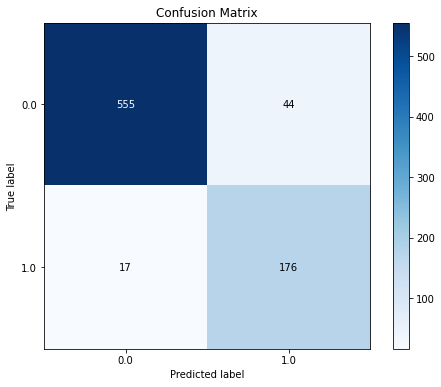

In [303]:
fig, ax = plt.subplots(figsize=(8, 6))
plot_confusion_matrix(lst_y_valid, valid_preds, ax=ax)
neptune.log_image('diagnostic_charts', fig)

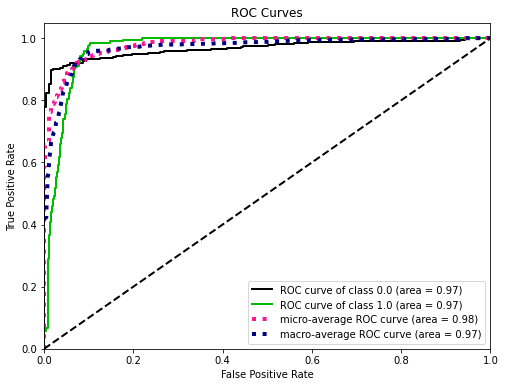

In [304]:
fig, ax = plt.subplots(figsize=(8, 6))
plot_roc(lst_y_valid, valid_probs2d, ax=ax)
neptune.log_image('diagnostic_charts', fig)

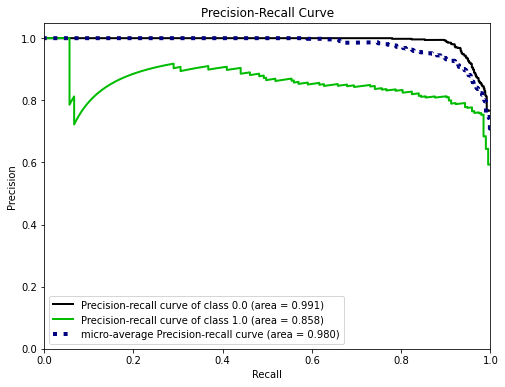

In [305]:
fig, ax = plt.subplots(figsize=(8, 6))
plot_precision_recall(lst_y_valid, valid_probs2d, ax=ax)
neptune.log_image('diagnostic_charts', fig)

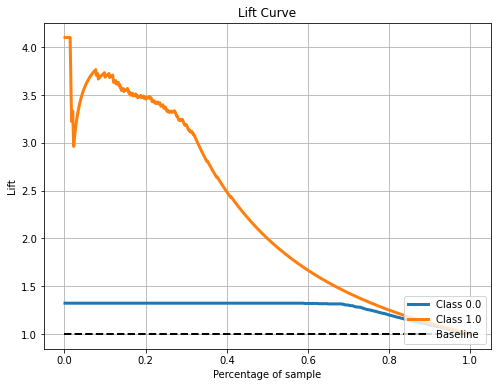

In [306]:
fig, ax = plt.subplots(figsize=(8, 6))
plot_lift_curve(lst_y_valid, valid_probs2d, ax=ax)
neptune.log_image('diagnostic_charts', fig)

# Model Prediction on Test data using ktrain

In [307]:
# ktrain.get_predictor?

In [308]:
%%time
predictor = ktrain.get_predictor(learner.model, preproc)

CPU times: user 41 µs, sys: 13 µs, total: 54 µs
Wall time: 57.2 µs


In [309]:
[i for i in dir(predictor) if i[0]!='_']

['analyze_valid',
 'batch_size',
 'c',
 'explain',
 'get_classes',
 'model',
 'predict',
 'predict_proba',
 'preproc',
 'save']

In [310]:
predictor.get_classes()

['not_label', 'label']

In [311]:
df_train['label'].unique()

array([0., 1.])

In [312]:
# we have actually labels 0 and 1 but ktrain gives not_label and label
# 0 is not_label
# 1 is label

In [313]:
one_sent = df_test[maincol].iloc[0]
one_sent

"I hate the new #iphone upgrade. Won't let me download apps. #ugh #apple sucks"

In [314]:
predictor.predict(one_sent)

'label'

In [315]:
%%time
predictor.explain(one_sent)

CPU times: user 6.03 s, sys: 2.39 s, total: 8.42 s
Wall time: 59.6 s


In [316]:
neptune.log_text('one_sent_explain_time','1 min')

In [317]:
X_test = df_test[maincol].to_numpy()

In [318]:
%%time
test_preds = predictor.predict(X_test,return_proba=False)

CPU times: user 4.65 s, sys: 1.95 s, total: 6.6 s
Wall time: 48.5 s


In [319]:
neptune.log_text('test_preds_time','1min 27s')

In [320]:
df_test[target] = test_preds

In [321]:
df_sub = df_test[['id','label']]
df_sub['label'] = df_sub['label'].replace({'not_label': 0, 'label': 1})

df_sub.to_csv('sub_ktrain_bert_ngram_range1_epochs2_maxlen300.csv', index=False)

In [324]:
# upload the data and get the score
neptune.log_metric('test_f1', 0.907575339598019 )

In [323]:
best_so_far = """
bert lr=2e-5 epochs=5 ngram_range=1 maxlen=300
f1 = 0.908687336005899

n_gram=2 gave worse result
tweet_clean_emoji gave worse result


"""
neptune.log_text('best_so_far',
                 best_so_far)